## Fresnel Transfer Function Approach

1. Given wavelength ($\lambda$),z, and the largest width of the aperture $l$, calculate the Fresnel Number $N_f$ appropriate for the entire aperture.
2. Choose an acceptable level of aliasing at the edge of the diffraction pattern.
3. Start by assuming that the aperture is rectangular, even though it may not be. Choose M, Q, and N=QM based on Figure 5.5
4. Create the padded aperture array of size NxN centered at index (N/2, N/2)
5. Create the quadratic-phase exponential transfer function array of length NxN, centered at index (N/2, N/2)
6. Perform a DFT on the aperture array, using an FFT algorithm. Center the result at index (N/2, N/2)
7. Multiply the two spectral arrays together element by element and perform an inverse DFT on the product, again using the FFT algorithm.
8. Circularly shift the center of the resulting sequence from indices (0,0) to indicies (N/2, N/2)
9. If intensity is of interest, take the squared magnitude of each element in the result of the inverse DFT. 
10. Experiment by increasing or decreasing M to determine its minimum allowable value that will satisfy the aliasing criterion. Choose Q=M/(4Nf) and adjust this value if necessary to yield good results.

In [20]:
#Import some packages that we will need
import torch
import matplotlib.pyplot as plt
import pint
import numpy as np

u = pint.UnitRegistry()

plt.style.use(['science','notebook'])

%matplotlib ipympl

In [21]:
#Now let's define our aperture width, our wavelength, and our propagation distance

#Aperture Width
l = 0.1 * u.mm

#Wavelength
wavelength = 660 * u.nm

#Propagation Distance
z = 3 * u.cm

#Wavenumber (k)
wavenumber = 2*np.pi/wavelength

In [22]:
#1) Find our Fresnel Number
N_f = ( (l/2)**2 ) / (wavelength * z)
N_f = N_f.to_base_units()

if N_f < 0.25:
    print(f"Nf = {N_f.magnitude} - We are in the Far Field")
else:
    print(f"Nf = {N_f.magnitude} - We are in the Near Field")

Nf = 0.12626262626262627 - We are in the Far Field


In [23]:
#2) Choose acceptable aliasing
aliasing_error = 1e-3 #Pretty arbitrary, should experiment with this

In [24]:
#3) M, Q, N

#Samples in the open aperture
M = 15

#Sampling Ratio
Q = M / (4*N_f)
Q = Q.to_base_units()

#Total width of the aperture
L = wavelength * z * M / l
L = L.to_compact()

#Total number of samples in the simulation
N = Q * M

#Sample spacing in the aperture plane
dx = L / N
dy = dx
#Sample spacing in the Frequency domain
dfx = 1 / L
dfy = dfx

print(f"M = {M}")
print(f"Q = {Q}")
print(f"N = {N}")
print(f"L = {L}")

M = 15
Q = 29.7 dimensionless
N = 445.5 dimensionless
L = 2.97 millimeter


In [25]:
#4) Create the NxN padded aperture array centered at (N/2, N/2)
# we will embed the open aperture in this array
x = np.linspace((-L/2).magnitude, (L/2).magnitude, int(N.to_base_units().magnitude)) *u.mm
y = x
xx,yy = np.meshgrid(x,y)

#Embed an aperture in the array
U0 = (np.abs(xx) < l / 2) * (np.abs(yy) < 0.5 * u.mm)
U0 = U0.astype(float)


In [26]:
len(x)

445

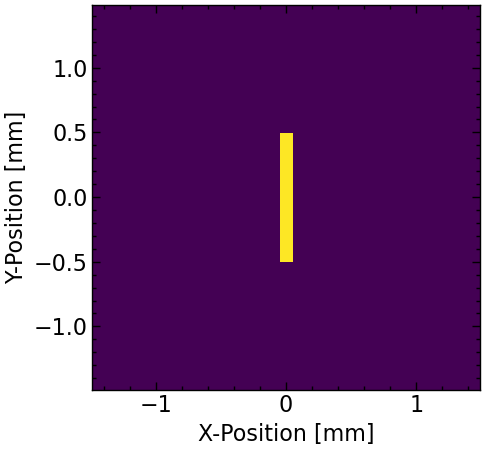

In [27]:
#Plot it to see the aperture
plt.figure(figsize=(5,5))
plt.pcolormesh(xx,yy,U0)
plt.xlabel('X-Position [mm]')
plt.ylabel('Y-Position [mm]')
plt.show()

In [130]:
#5) Create the quadratic-phase exponential transfer function array 
kx = np.fft.fftfreq(len(x), np.diff(x)[0]) * 2 * np.pi
ky = kx

kxv, kyv = np.meshgrid(kx,ky)

#H = np.exp(1j*z*np.sqrt(wavenumber**2-kxv**2-kyv**2))

In [131]:
#6) Perform the DFT of the apertuce and then center
A = np.fft.fft2(U0)

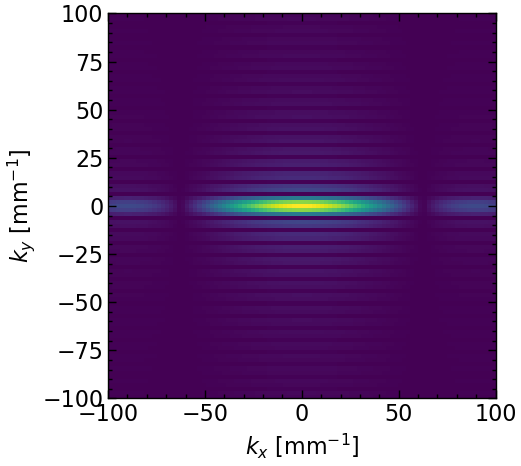

In [132]:
plt.figure(figsize=(5,5))
plt.pcolormesh(np.fft.fftshift(kxv.magnitude), np.fft.fftshift(kyv.magnitude), np.abs(np.fft.fftshift(A)))
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.xlabel('$k_x$ [mm$^{-1}$]')
plt.ylabel('$k_y$ [mm$^{-1}$]')
plt.show()

In [133]:
H = np.exp(1j * wavenumber * z) * np.exp(-1j * 0.5 * z * wavelength / (2* np.pi) * (kxv**2 + kyv**2))
#H = np.exp(1j * wavenumber * z) * np.exp(-1j * np.pi * wavelength * z * (kxv**2 + kyv**2))

In [134]:
#7) Multiply
U_ = A * H
U_ = np.fft.ifft2(U_.magnitude)
U = np.fft.ifft2(A * np.exp(1j*z*np.sqrt(wavenumber**2-kxv**2-kyv**2)).magnitude)

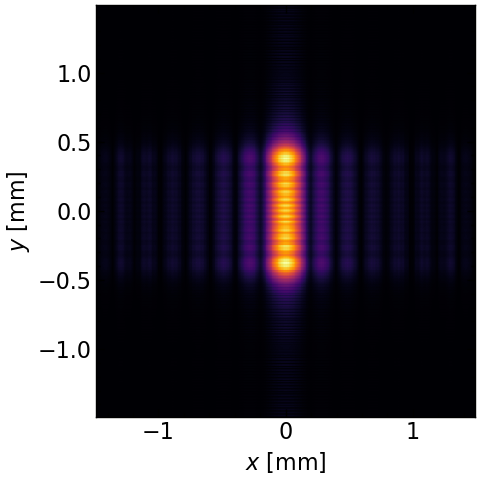

In [137]:
plt.figure(figsize=(5,5))
plt.pcolormesh(xx,yy,np.abs(U_), cmap='inferno')
plt.xlabel('$x$ [mm]')
plt.ylabel('$y$ [mm]')
plt.tight_layout()
plt.show()